<a href="https://colab.research.google.com/github/txusser/Master_IA_Sanidad/blob/main/2.3.1_Red_Neuronal_Python_B%C3%A1sico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importaciones de librerías necesarias

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn. datasets import make_circles



Creamos el dataset que vamos a tratar de clasificar y le echamos. Recordaremos que este problema no se puede solucionar con un perceptrón directamente, ya que las categorías no son separables de forma lineal


In [36]:
# Creamos el dataset

n = 500 # Número de muestras
p= 2 # Número de características por muestra

X,Y = make_circles(n_samples=n, noise = 0.1, factor=0.5)
Y = Y[:, np.newaxis]
X.shape

(500, 2)

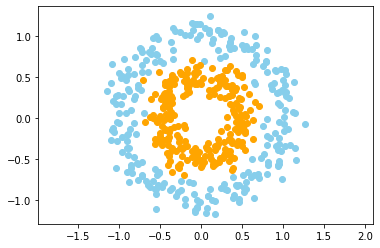

In [29]:
#Plot de las distintas partes del dataset que acabamos de crear

plt.scatter(X[Y[:,0]==0,0], X[Y[:,0]==0,1], c="skyblue")
plt.scatter(X[Y[:,0]==1,0], X[Y[:,0]==1,1], c="orange")
plt.axis("equal")
plt.show()

Ahora debemos crear la estructura de nuestra red neuronal. 
Vamos a empezar por crear una clase que defina cada capa de nuestra red. 

El parámetro número de conexiones (n_conn) se refiere al número de entradas (Conexiones desde la capa anterior). EL parámetro n_neur se refiere al número de neuronas de la capa actual.

In [30]:
class neural_layer():
  def __init__(self, n_conn, n_neur, act_f):

    self.act_f = act_f
    self.b = np.random.rand(1, n_neur)*2 -1 # generamos aleatoriamente un vector con los bias de nuestra capa.
                                        # Les asignamos un valor inicial aleatorio normalizado entre -1 y 1.
    self.W = np.random.rand(n_conn, n_neur)*2-1 # Lo mismo con la matriz de pesos.

Creamos ahora nuestra función de activación. Implementamos tanto la función sigmoide como la función relu, para tenerlas disponibles posteriormente. Cada función incluye también su derivada, ya que como sabemos, vamos a necesitar la derivada de la función sigmoide a la hora de calcular el gradiente.

Por ejemplo, en le función sigm tenemos un primer elemento

1 / (1+ np.e ** (-x))

para la función sigmoide, y un segundo término

lambda x: x*(1-x)

para su derivada. Podemos acceder a la función sigmoide o a su derivada haciendo simplemente sigm[0] y sigm[1]



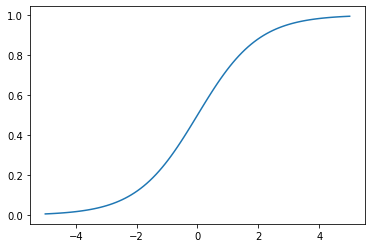

In [31]:
sigm = (lambda x: 1 / (1+ np.e ** (-x)), lambda x: x*(1-x))
relu = (lambda x: x if x > 0 else 0, lambda x: 1 if x > 0 else 0)

# Vamos a plotear ambas funciones para ver si está todo correcto
_x = np.linspace(-5,5,100)
y = [sigm[0](i) for i in _x]
plt.plot(_x,y)

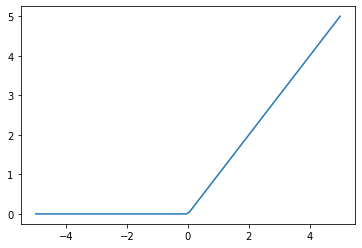

In [32]:
y = [relu[0](i) for i in _x]
plt.plot(_x,y)

Creamos ahora una clase que cree una red neuronal añadiendo capas. Vamos a crear una red neuronal con 5 capas internas, siendo p nuestro número de entradas, definido anteriormente, y 1 una capa de salida con una única neurona.

In [33]:


def create_nn(topology, act_f):
  
  nn = []

  for l, layer in enumerate(topology[:-1]):

    nn.append(neural_layer(topology[l], topology[l+1], act_f))

  return nn


Hasta ahora hemos sido capaces de crear una red neuronal. Sin embargo, no hemos creado nada de la lógica necesaria para entrenar a nuestra red neuronal. 

Como ya hablamos en el tema sobre redes neuronales, el entrenamiento de la red neuronal tiene 3 pasos diferenciados. 

1.   Un paso hacia adelante, en el que proporcionamos a la red variables de entrada, dejamos que la red los procese y obtenemos una salida.  
2.   El segundo elemento sería, una vez tenemos una salida, la compararíamos con la salida esperada (Y), haciendo uso de una función de coste, que nos permitiría medir el error en nuestra red.
3.   Finalmente, haríamos uso del backpropagation para propagar hacia atrás ese error, calculando las derivadas parciales y atribuyendo una parte de error a cada neurona, y las minimizaríamos haciendo uso del descenso del gradiente.






In [37]:
# Definamos la función de coste como el error cuadrático medio, que vimos 
# en la parte teórica sobre redes neuronales

l2_cost = (lambda Yp, Yr: np.mean((Yp-Yr)**2), lambda Yp, Yr: (Yp-Yr))

def train(neural_net, X, Y, l2_cost,lr=0.5, train=True):

  out = [(None,X)]
  # Paso 1: Paso hacia adelante
  for l, layer in enumerate(neural_net):

    # Empezamos haciendo la suma ponderada
    z = out[-1][1] @ neural_net[l].W + neural_net[l].b
    # Ahora aplicamos la función de activación
    a = neural_net[l].act_f[0](z)

    out.append((z,a))

  # El ultimo elemento del vector out contiene ahora la salida de la red para cada elemento. 
  # Paso 2: Ahora podemos utilizar la función de coste para calcular el error y actualizar los pesos
  
  if train:
    
    deltas = []

    for l in reversed(range(0,len(neural_net))):

      z = out[l+1][0]
      a = out[l+1][1]


      if l == len(neural_net) - 1:
        # Paso 2: Calculamos el error con la función de coste en la última capa.
        deltas.insert(0,l2_cost[1](a,Y) * neural_net[l].act_f[1](a))
      else:
        # Calculamos el error para el resto de las capas con la fórmula de backpropagation
        deltas.insert(0,deltas[0] @ _W.T * neural_net[l].act_f[1](a))
        
        #Guardamos los pasos antes de utilizarlos para utilizarlos en la siguiente actualización
      _W = neural_net[l].W

      # Actualizamos los parámetros utilizando el descenso del gradiente
      neural_net[l].b = neural_net[l].b - lr * np.mean(deltas[0], axis=0, keepdims=True)
      neural_net[l].W = neural_net[l].W - lr * out[l][1].T @ deltas[0]
    

  return out[-1][1]





Ahora que hemos implementado el proceso de entrenamiento, vamos a iterar para actualizar iterativamente los pesos. LLegado el momento, nuestra red neuronal habrá encontrado una solución para el problema.

Aunque el código mostrado a continuación parece largo y complejo, la parte importante, y que se encargará del entrenamiento, es la siguiente:

for i in range(5000):

  pY = train(neural_net, X, Y, l2_cost, lr=0.025)

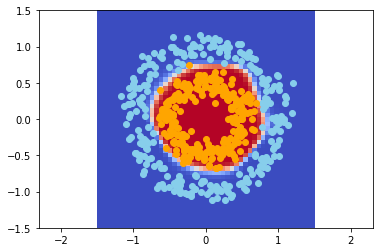

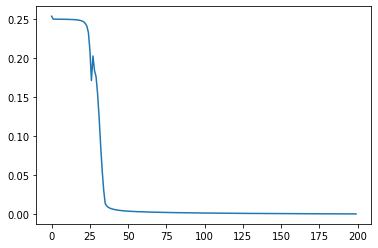

In [49]:
# Vamos a probar nuestra red neuronal

import time
from IPython.display import clear_output

topology = [p,4,8,4,1]
neural_net = create_nn(topology, sigm)

loss = []

for i in range(5000):

  #Iteramos sobre el proceso de entrenamiento!

  pY = train(neural_net, X, Y, l2_cost, lr=0.025)

  if i % 25 == 0:

    loss.append(l2_cost[0](pY,Y))

    print(loss[-1])

    res = 50

    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5 ,1.5, res)

    _Y = np.zeros((res,res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0,i1] = train(neural_net, np.array([[x0,x1]]), Y, l2_cost, train=False)[0][0]
    plt.pcolormesh(_x0,_x1,_Y, cmap="coolwarm")
    plt.axis("equal")

    plt.scatter(X[Y[:,0]==0,0], X[Y[:,0]==0,1], c="skyblue")
    plt.scatter(X[Y[:,0]==1,0], X[Y[:,0]==1,1], c="orange")

    clear_output(wait=True)
    plt.show()
    plt.plot(range(len(loss)), loss)
    plt.show()
    time.sleep(0.5)
